In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import ipdb
import numpy as np
import os
import pickle
from IPython.core.debugger import set_trace

# model
#from reg_loss_vae_more_layers import RegLossVAE
from celebA_vae import CelebAVAE

# load loss functions
import sys
sys.path.append('./../../loss')
from loss_provider import LossProvider

# Constants

In [2]:
dataset_path = './../../datasets/celebA/images/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
data_dim = (3,64,64)
data_size = np.prod(data_dim)
batch_size = 64

# Load Data

In [3]:
# key word args for loading data
kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda" else {}

dataset = datasets.ImageFolder(dataset_path, transform=transforms.ToTensor())
data_size = len(dataset)
train_size = int(0.9 * data_size)
test_size = data_size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# load datasets and make them easily fetchable in DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# load datasets and make them easily fetchable in DataLoaders
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# Auxillary functions

In [4]:
# helper function
to_img = transforms.ToPILImage()

reconstruction samples:


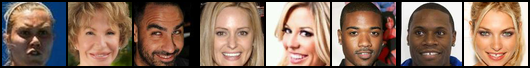

In [5]:
np.random.seed(0)
idx = np.random.randint(0,len(test_set),8)
sample_set = [test_set[i][0].numpy() for i in idx]
sample_set = torch.tensor(sample_set, dtype=torch.float32)
sample_set = sample_set.to(device)

grid = torchvision.utils.make_grid(sample_set.cpu(), nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
print('reconstruction samples:')
to_img(grid)

In [6]:
def sample_reconstruction(model, logger):
    # plots reconstruction of a couple inputs
    with torch.no_grad():
        z, _ = model.encode(sample_set)
        recon = model.decode(z)
    comparison = torch.cat([sample_set[:8], recon[:8],sample_set[8:], recon[8:]])
    torchvision.utils.save_image(comparison.cpu(),
             logger.path + 'reconstruction_' + str(logger.minibatch) + '.png', nrow=8)

interpolation samples:


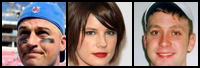

In [7]:
interpol_set = torch.cat([test_set[i][0].expand((1,) + data_dim) for i in range(3)])
        
interpol_set = torch.as_tensor(interpol_set, dtype=torch.float32)
interpol_set = interpol_set.to(device)

grid = torchvision.utils.make_grid(interpol_set.cpu(), nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
print('interpolation samples:')
to_img(grid)

In [8]:
def sample_interpol(model, logger):
    # plots interpolation of a couple inputs
    with torch.no_grad():
        N = 16
        zs = model.encode(interpol_set)[0].detach().cpu().numpy()
        if zs.shape[1] == 2:
            # 2 dimensional latent space. Interpolate over entire latent space
            z0 = np.array([-2., 2.])
            z0to1 = np.array([4., 0.])
            z0to2 = np.array([0., -4.])
        else:
            # multi-dimensional latent space. interpolate between samples
            z0 = zs[0]
            z0to1 = zs[1] - z0
            z0to2 = zs[2] - z0
        zs = []
        for y in range(N):
            for x in range(N):
                zs.append(z0 + z0to1 * (x/(N-1)) + z0to2 * (y/(N-1)))
        zs = torch.tensor(zs, dtype=torch.float32)
        zs = zs.to(device)
        recon = model.decode(zs)
    torchvision.utils.save_image(recon.cpu(),
             logger.path + 'interpol_' + str(logger.minibatch) + '.png', nrow=N)

In [9]:
def sample_latents(model, n, epoch, logger):
    # samples random values from latent space
    with torch.no_grad():
        sample = torch.randn(n, model.latent_space).to(device)
        sample = model.decode(sample).cpu()
        torchvision.utils.save_image(sample.view(n, data_dim[0], data_dim[1], data_dim[2]),
                   logger.path + 'sample_' + str(logger.minibatch) + '.png')

In [10]:
def load_model(output_path):
    model = torch.load(output_path + 'model.pckl')
    logger = pickle.load(open(output_path + 'log.pckl', "rb"))
    loss_fun = pickle.load(open(output_path + 'loss_fun.pckl', "rb"))
    return logger, model, loss_fun

In [11]:
def save_model(logger, model, loss_fun):
    torch.save(model, logger.path + 'model.pckl')
    pickle.dump(logger, open(logger.path + 'log.pckl', "wb"))
    pickle.dump(loss_fun, open(logger.path + 'loss_fun.pckl', "wb"))
    return

In [12]:
class Logger():
    def __init__(self, path):
        self.path = path
        self.minibatch = 0
        
        # make output dir
        if not os.path.isdir(self.path):
            os.mkdir(self.path)
        
        stats = {}
        for l in ['train', 'test']:
            stats[l] = {'losses': [],
                         'recon_losses': [],
                         'recon_losses2': [],
                         'kl_losses': [],
                         'mean_z': [],
                         'var_z': [],
                         'var_mu': [],
                         'idx': []}
        self.stats = stats
        return
        
    def train_step(self, kl_loss, recon_loss, recon_loss2, z, mu):
        self.step('train', self.minibatch, kl_loss, recon_loss, recon_loss2, z, mu)
        self.minibatch += 1
        return
        
    def test_step(self, kl_loss, recon_loss, recon_loss2, z, mu):
        return self.step('test', self.minibatch, kl_loss, recon_loss, recon_loss2, z, mu)
    
    def step(self, env, idx, kl_loss, recon_loss, recon_loss2, z, mu):
        """
        logs one training step
        """
        self.stats[env]['recon_losses'].append(recon_loss.item() / batch_size)
        self.stats[env]['recon_losses2'].append(recon_loss2.item() / batch_size)
        self.stats[env]['kl_losses'].append(kl_loss.item() / batch_size)
        self.stats[env]['losses'].append(recon_loss.item() + kl_loss.item() / batch_size)
        self.stats[env]['mean_z'].append(z.mean().item())
        self.stats[env]['var_z'].append(z.var().item())
        self.stats[env]['var_mu'].append(mu.var().item())
        self.stats[env]['idx'].append(idx)
        return
    
    def plot(self):
        if 2 >= len(self.stats['train']['losses']):
            print('need at least 2 epochs of data for plot')
            return
        xs_train = self.stats['train']['idx']
        xs_test = self.stats['test']['idx']

        # Two subplots, unpack the axes array immediately
        f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(6,8))
        ax1.semilogy(xs_train, self.stats['train']['recon_losses'], label='train')
        ax1.semilogy(xs_test, self.stats['test']['recon_losses'], label='test')
        ax1.set_ylabel('$\mathcal{L}_{rec}$')
        ax1.legend(loc="upper right")
        ax2.plot(xs_train, self.stats['train']['mean_z'])
        ax2.plot(xs_test, self.stats['test']['mean_z'])
        ax2.set_ylabel('$\mu(z)$')
        ax3.plot(xs_train, self.stats['train']['var_z'])
        ax3.plot(xs_test, self.stats['test']['var_z'])
        ax3.set_ylabel('$\sigma^2(z)$')
        ax4.plot(xs_train, np.array(self.stats['train']['var_z']) - np.array(self.stats['train']['var_mu']))
        ax4.plot(xs_test, np.array(self.stats['test']['var_z']) - np.array(self.stats['test']['var_mu']))
        ax4.set_xlabel('Minibatch')
        ax4.set_ylabel('$\sigma^2(z) - \sigma^2(\mu(X))$')
        f.savefig(self.path + 'training.pdf')
        plt.close(fig=f)
        return
    
    def plot_loss_comparison(self):
        if 2 >= len(self.stats['train']['losses']):
            # print('need at least 2 epochs of data for plot')
            return
        xs_train = self.stats['train']['idx']
        xs_test = self.stats['test']['idx']
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))
        ax1.semilogy(xs_train, self.stats['train']['recon_losses'], label='train')
        ax1.semilogy(xs_test, self.stats['test']['recon_losses'], label='test')
        ax1.set_ylabel('$\mathcal{L}_{rec}$ of training objective')
        ax1.legend(loc="upper right")
        ax2.semilogy(xs_train, self.stats['train']['recon_losses2'], label='train')
        ax2.semilogy(xs_test, self.stats['test']['recon_losses2'], label='test')
        ax2.set_ylabel('other $\mathcal{L}_{rec}$ metric')
        ax2.set_xlabel('Minibatch')
        f.savefig(self.path + 'comparison.pdf')
        plt.close(fig=f)
        return

# KL-loss

In [13]:
def regularization_loss(mu, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2), sum is over all dim of the latent distribution z
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD

# Train function

In [14]:
def train_step(epoch, model, train_set, loss_fun, loss_fun_comparison, lam, optimizer, logger): # train for one epoch
    # set model to training mode, affects eg. dropout layers
    model.train() 
    
    for (data, _label) in train_set: # iterate over minibacthes
        data = data.to(device) # cast data to gpu
        optimizer.zero_grad() # set gradients to 0

        recon_batch, mu, logvar, z = model(data) # run model
        
        # calculate loss
        reconstruct_loss = lam * loss_fun(recon_batch, data)
        kl_loss = regularization_loss(mu, logvar)
        loss = reconstruct_loss + kl_loss
        
        if loss_fun_comparison is None:
            reconstruct_loss2 = torch.tensor([0.])
        else:
            reconstruct_loss2 = lam * loss_fun_comparison(data, recon_batch)
        
        # propagate loss
        loss.backward()
        optimizer.step()  
        
        
        # log
        logger.train_step(kl_loss, reconstruct_loss, reconstruct_loss2, z, mu)
        
    return loss.item()

# Test function

In [15]:
def test_step(epoch, model, test_set, loss_fun, loss_fun_comparison, lam, logger): # train for one epoch
    # set model to eval mode, affects eg. dropout layers
    model.eval() 
    
    with torch.no_grad():
        for data, _label in test_set: # iterate over minibacthes
            data = data.to(device) # cast data to gpu
            recon_batch, mu, logvar, z = model(data) # run model

            # calculate loss
            reconstruct_loss = lam * loss_fun(recon_batch, data)
            kl_loss = regularization_loss(mu, logvar)
            loss = reconstruct_loss + kl_loss
            
            if loss_fun_comparison is None:
                reconstruct_loss2 = torch.tensor([0.])
            else:
                reconstruct_loss2 = lam * loss_fun_comparison(data, recon_batch)

            # log
            logger.test_step(kl_loss, reconstruct_loss, reconstruct_loss2, z, mu)
                
    return loss.item()

# Main programm

In [16]:
def adjust_learning_rate(optimizer, epoch, initial_lr, lr_decline=(0.5 ** (1/20))):
    """declines the learning rate by a factor of $\sqrt{20}{0.5}$ ever epoch, a reduction by half over every 20 epochs"""
    lr = initial_lr * lr_decline**epoch
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
def train_model(model, train_set, test_set, loss_fun, loss_fun_comparison=None, lam=1, epochs=10, initial_lr=5e-4,  logger=Logger('./results/')):
    model = model.to(device)
    loss_fun = loss_fun.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    lowest_loss = 99999
    
    # train
    for epoch in tqdm(range(epochs)):
        adjust_learning_rate(optimizer, epoch, initial_lr)
        logger.plot()
        if not(loss_fun_comparison is None):
            logger.plot_loss_comparison()

        train_step(epoch, model, train_set, loss_fun, loss_fun_comparison, lam, optimizer, logger)
        
        loss = test_step(epoch, model, test_set, loss_fun, loss_fun_comparison, lam, logger)

        #clear_output()
        sample_latents(model, 64, epoch, logger)
        sample_interpol(model, logger)
        sample_reconstruction(model, logger)
        
        
            
        # checkpoint
        if loss < lowest_loss:
            lowest_loss = loss
            save_model(logger, model, loss_fun)
            
    return logger, model

# Running Model

In [18]:
provider = LossProvider()
print('available modes: {}'.format(provider.color_models))
print('available loss functions: {}'.format(provider.loss_functions))

available modes: ['LA', 'RGB']
available loss functions: ['L1', 'L2', 'SSIM', 'Watson-dct', 'Watson-fft', 'Watson-vgg', 'Deeploss-vgg']


In [ ]:
# trains l2 loss comparison
for loss_name in ['deeploss',]:
    for lam in [10]:
        print('evaluating function {} with lambda e^{}'.format(loss_name, lam))
        model = CelebAVAE(latent_space=256, input_size=data_dim)
        loss_fun = provider.get_loss_function(loss_name, 'RGB')
        train_model(model=model, 
                            train_set=train_loader, 
                            test_set=test_loader, 
                            loss_fun=loss_fun,
                            loss_fun_comparison=None,
                            lam=np.exp(lam),
                            epochs=100,
                            initial_lr=1e-4,
                            logger=Logger('./results/' + loss_name + '_lam_e'+str(lam)+'/')
                   )

evaluating function deeploss with lambda e^10


need at least 2 epochs of data for plot


/home/steffen/study/VAE-perceptual-loss/venv-pytorch/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


# Resume training

In [ ]:
#logger, model, loss_fun = load_model('./results/watson-fft_lam_e-3/')

In [ ]:
#train_model(model=model, 
            train_set=train_loader, 
            test_set=test_loader, 
            loss_fun=loss_fun,
            loss_fun_comparison=None,
            lam=np.exp(-3),
            epochs=1000,
            initial_lr=1e-4,
            logger=logger)